
## Prerequisites

gensim==3.6.0

In [1]:
import os

from ast import literal_eval

from string import punctuation

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.models import FastText

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from scipy.sparse import lil_matrix

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split


lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

In [2]:
import numexpr as ne

ne.set_num_threads(ne.detect_number_of_cores())

4

In [3]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

In [4]:
def preprocess_text(tokenizer, lemmatizer, stop_words, punctuation, text): 
    tokens = tokenizer(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return [token for token in lemmas if token not in stop_words and token not in punctuation]

In [5]:
bool_load = True

if not bool_load:
    df['cleaned'] = df.comment_text.apply(lambda x: preprocess_text(word_tokenize, lemmatizer, stop_words, punctuation, x))

In [6]:
bool_save = False

if bool_save:
    df.to_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

In [7]:
df_sample = df.sample(100000)

In [8]:
df_sample.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned
44812,44812,77ba1bc433cb3b42,"""\n Everything here needs a reliable source, a...",0,0,0,0,0,0,"['``', 'everything', 'need', 'reliable', 'sour..."
140776,140776,f14f97aae7979821,"""\nBy the way, has anyone asked you to """"spend...",0,0,0,0,0,0,"['``', 'way', 'ha', 'anyone', 'asked', '``', ""..."
67623,67623,b4f1b69eebcf8a59,Appreciate your comments. I will wait to post ...,0,0,0,0,0,0,"['appreciate', 'comment', 'wait', 'post', 'wan..."
57673,57673,9a537465570c5920,May 2008 \n Please stop your disruptive editin...,0,0,0,0,0,0,"['may', '2008', 'please', 'stop', 'disruptive'..."
158700,158700,f219d5ccdb818606,"""\nI did and have replied on your talk page. -...",0,0,0,0,0,0,"['``', 'replied', 'talk', 'page', '✰✰', 'echo'..."


### Train the model from scratch

Train our first model based on the vocabulary from df_sample: 

In [9]:
# With initialization model trained for 5 epochs 

df_sample_cleaned_list = [literal_eval(s) for s in df_sample.cleaned.tolist()]

model = Word2Vec(sentences=df_sample_cleaned_list, 
         size=100,      # embedding vector size
         min_count=5,   # consider words that occured at least 5 times
         window=5)

In [15]:
# Continue training the model 

model.train(sentences=df_sample_cleaned_list, 
            total_examples=model.corpus_count,
            epochs=30
           )

(99633734, 117950070)

In [16]:
#model.wv.vocab # to look at vocabulary

In [17]:
model.wv.most_similar('people')

[('others', 0.6437145471572876),
 ('person', 0.6037046909332275),
 ('everyone', 0.5745449066162109),
 ('thing', 0.5650192499160767),
 ('way', 0.5321717858314514),
 ('admins', 0.5284237265586853),
 ('guy', 0.5068493485450745),
 ('wikipedians', 0.5053339004516602),
 ('someone', 0.49681389331817627),
 ('editor', 0.4963911771774292)]

### The next approach is to try to use the already pretrained model, which can be downloaded from here:

https://github.com/RaRe-Technologies/gensim-data

model:   
GoogleNews-vectors-negative300.bin

In [18]:
#os.getcwd()

In [19]:
model = KeyedVectors.load_word2vec_format(
    os.getcwd() + os.sep + "GoogleNews-vectors-negative300.bin", binary=True
)

In [20]:
# You can try to use GloVe model too and experiment with it: <- later
# import gensim.downloader as api
# model = api.load('glove-wiki-gigaword-100')

## Words distance 

# 1 - Cosine similarity

To measure how similar two words are, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

where $u.v$ is the dot product (or inner product) of two vectors, $||u||_2$ is the norm (or length) of the vector $u$, and $\theta$ is the angle between $u$ and $v$. This similarity depends on the angle between $u$ and $v$. If $u$ and $v$ are very similar, their cosine similarity will be close to 1; if they are dissimilar, the cosine similarity will take a smaller value. 

<img src="cosine_sim.png" style="width:800px;height:250px;">
<caption><center> **Figure 1**: The cosine of the angle between two vectors is a measure of how similar they are</center></caption>

**Exercise**: Implement the function `cosine_similarity()` to evaluate similarity between word vectors.

**Reminder**: The norm of $u$ is defined as $ ||u||_2 = \sqrt{\sum_{i=1}^{n} u_i^2}$

In [21]:
def cosine_similarity(w1, w2):
    """
    Cosine similarity between w1 and w2
    
    Arguments:
        w1 : word vector        
        w2 : word vector 
    Returns:
        cosine_similarity 
    """
    if (not np.any(w1) or not np.any(w2)): # check input is not zero-vector
        return 0
    
    # Dot product between w1 and w2
    dot = np.dot(w1, w2)
    # L2 norm of w1
    norm_u = np.linalg.norm(w1) 
    # L2 norm of w2 
    norm_v = np.linalg.norm(w2) 
    # Cosine similarity 
    cosine_similarity = dot / (norm_u * norm_v)
    
    return cosine_similarity

In [22]:
father = model.get_vector("father")
mother = model.get_vector("mother")

ball = model.get_vector("ball")
crocodile = model.get_vector("crocodile")

france = model.get_vector("france")
paris = model.get_vector("paris")
italy = model.get_vector("italy")
rome = model.get_vector("rome")

kiev = model.get_vector("kiev")
ukraine = model.get_vector("ukraine")

In [23]:
fast_print = lambda u, v, tag1, tag2: print(
    "cosine_similarity({t1}, {t2}) = ".format(t1 = tag1, t2 = tag2), cosine_similarity(u, v)
)

fast_print(father, mother, "father", "mother")
fast_print(ball, crocodile, "ball", "crocodile")
fast_print(france - paris, rome - italy, "france - paris", "rome - italy")
fast_print(kiev, ukraine, "kiev", "ukraine")

cosine_similarity(father, mother) =  0.79014826
cosine_similarity(ball, crocodile) =  0.10283584
cosine_similarity(france - paris, rome - italy) =  -0.1988747
cosine_similarity(kiev, ukraine) =  0.3738725


**Approximate expected output**:

<table>
    <tr>
        <td>
            **cosine_similarity(father, mother)** =
        </td>
        <td>
         0.79014826
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(ball, crocodile)** =
        </td>
        <td>
         0.10283585
        </td>
    </tr>
        <tr>
        <td>
            **cosine_similarity(france - paris, rome - italy)** =
        </td>
        <td>
         -0.421037
        </td>
    </tr>
</table>

## 2 - Word analogy task

In the word analogy task, we complete the sentence <font color='brown'>"*a* is to *b* as *c* is to **____**"</font>. An example is <font color='brown'> '*man* is to *woman* as *king* is to *queen*' </font>. In detail, we are trying to find a word *d*, such that the associated word vectors $e_a, e_b, e_c, e_d$ are related in the following manner: $e_b - e_a \approx e_d - e_c$. We will measure the similarity between $e_b - e_a$ and $e_d - e_c$ using cosine similarity. 

**Exercise**: Complete the code below to be able to perform word analogies!

***Note***: here you will need to complete a function in the sections, which are marked as:

```
# ----- Start ----- #
Your code should be written in-between the lines
# ------ End ------ #
```


In [24]:
def find_word_analogy(word_1, word_2, word_3, model):
    """
    Finds the word to complete analogy (see explanation above): a is to b as c is to ____. 
    
    Arguments:
    word_1 -- a word, string
    word_2 -- a word, string
    word_3 -- a word, string
    model -- word embeddings model 
    
    Returns:
    best_word --  the word such that v_1 - v_2 is close to v_best_word - v_3, as measured by cosine similarity
    """
    # convert words to lower case
    word_1, word_2, word_3 = word_1.lower(), word_2.lower(), word_3.lower()
    
    # ----- Start ----- #
    # Get the word embeddings v_a, v_b and v_c (≈1-3 lines)
    fast_get = lambda word: model.get_vector(word)
    e_1, e_2, e_3 = tuple(map(fast_get, [word_1, word_2, word_3]))
    # ------ End ------ #
    
    words = list(model.vocab.keys())
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None

    # Loop over the whole word vector set
    for w in words:        
        e_j = fast_get(w)
        # to avoid best_word being one of the input words, skip them and continue iteration.
        if w in [word_1, word_2, word_3]:
            continue
        
        # ----- Start ----- #
        # Compute cosine similarity between the vector (e_2 - e_1) and the vector ((w's vector) - e_3)
        cosine_sim = cosine_similarity(e_2 - e_1, e_j - e_3)
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
        # do not forget to set new max_cosine_sim to the current value and best_word as well
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        # ------ End ------ #
        
    return best_word

In [25]:
triads_to_try = [
    ('man', 'woman', 'king'), 
    ('bad', 'good', 'sad'), 
    ('man', 'woman', 'boy'), 
    ('small', 'smaller', 'large')
]

for triad in triads_to_try:
    print('{} -> {} :: {} -> {}'.format(*triad, find_word_analogy(*triad, model)))

man -> woman :: king -> queen
bad -> good :: sad -> wonderful
man -> woman :: boy -> girl
small -> smaller :: large -> larger


**Expected Output**:

<table>
    <tr>
        <td>
            **man -> woman** ::
        </td>
        <td>
         king -> queen
        </td>
    </tr>
        <tr>
        <td>
            **bad -> good** ::
        </td>
        <td>
         sad -> wonderful
        </td>
    </tr>
        <tr>
        <td>
            **man -> woman ** ::
        </td>
        <td>
         boy -> girl
        </td>
    </tr>
        <tr>
        <td>
            **small -> smaller ** ::
        </td>
        <td>
         large -> larger
        </td>
    </tr>
</table>

#### The next part of the task is to:  

1. Train your own W2V model using the proposed method above. Use all of the tokens created after your preprocessing pipeline in the previous tasks. (deleting stop_words, punctuation, lowercasing, etc - play as you want).  
2. Use obtained vectors to obtain text vectors using such pipeline: 
  1. For each word in a preprocessed text, get a word vector from the W2V model. 
  2. Add them together to obtain vectors for texts (sum them together, or get mean vector) 
3. Use obtained text vectors as a text representation to perform a text classification task.  
   Proposed - use binary classification (for example: select only 'obscene' text and clean and try to distinguish them one from another)
4. Calculate the metrics - TP, FP, FN, TN, precision, recall, F1 score, F2 score, accurary. 


In [10]:
from gensim.models.callbacks import CallbackAny2Vec


class callback_custom(CallbackAny2Vec):
    def __init__(self):
         self.epoch = 0

    def on_epoch_end(self, model):
        print("Iteration {:3}".format(self.epoch+1))
        self.epoch += 1

In [11]:
# init w2v model
n_dimensions = 300

model_w2v = Word2Vec(sentences=df_sample_cleaned_list, 
                     size=n_dimensions, min_count=5, window=5,
                     callbacks=[callback_custom()]
                    )

Iteration   1
Iteration   2
Iteration   3
Iteration   4
Iteration   5


In [12]:
# model training
number_of_iterations = 50

model_w2v.train(sentences=df_sample_cleaned_list, 
            total_examples=model_w2v.corpus_count,
            epochs=number_of_iterations
           )

Iteration   6
Iteration   7
Iteration   8
Iteration   9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
...
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55


(166018026, 196453500)

In [81]:
#model_w2v.wv.vocab

In [82]:
model_w2v.wv.most_similar('people')

[('others', 0.5206615328788757),
 ('thing', 0.4942361116409302),
 ('person', 0.4668040871620178),
 ("n't", 0.4607079327106476),
 ('way', 0.44727379083633423),
 ('everyone', 0.4458949565887451),
 ('admins', 0.4422728419303894),
 ('editor', 0.43506354093551636),
 ('someone', 0.4273918867111206),
 ('would', 0.42714184522628784)]

In [83]:
model_w2v.wv.most_similar('one')

[("n't", 0.48523271083831787),
 ('two', 0.47902488708496094),
 ('even', 0.4700774550437927),
 ('every', 0.44541630148887634),
 ('way', 0.44086700677871704),
 ('article', 0.43976253271102905),
 ("'s", 0.4374009966850281),
 ('think', 0.43113958835601807),
 ('first', 0.42464885115623474),
 ('another', 0.41953933238983154)]

In [84]:
bool_save_model = False

if bool_save_model:
    model_w2v.wv.save_word2vec_format('w2v_df_t2_clnd_sample.bin', binary = True)

In [85]:
model_w2v_vectors = model_w2v.wv # getting keyed vectors from trained model

In [13]:
from collections import Counter


def is_not_outliner(
    word: str, 
    counts: Counter,
    counts_lim_min: int = 5,
    length_lim_min: int = 3,
    length_lim_max: int = 20):
    return (counts[word] > counts_lim_min and (length_lim_min <= len(word) <= length_lim_max))


flat_nested = lambda fl: [e for l in fl for e in l]
fast_vocab = lambda l: set(flat_nested(l))

mess = [literal_eval(e) for e in df['cleaned'].tolist()]
cnts = Counter(flat_nested(mess))
cleaned_vocab = [t for t in fast_vocab(mess) if is_not_outliner(t, cnts)]
len(cleaned_vocab)

35290

In [7]:
text_categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'cleaned']

temp = df[[text_categories[4], text_categories[-1]]]

temp_n = temp[~df[text_categories[:-1]].any(axis = 'columns')]
temp_i = temp[df.insult != 0]

insulting_and_neutral = temp_i.append(temp_n).reset_index(drop = True)
insulting_and_neutral.columns = ['label', 'texts']

del temp, temp_n, temp_i

print(
    insulting_and_neutral.head(),
    insulting_and_neutral.tail(),
    sep = '\n\n'
)

   label                                              texts
0      1           ['cocksucker', 'piss', 'around', 'work']
1      1  ['gay', 'antisemmitian', 'archangel', 'white',...
2      1                ['fuck', 'filthy', 'mother', 'dry']
3      1  ['stupid', 'peace', 'shit', 'stop', 'deleting'...
4      1  ['=tony', 'sidaway', 'obviously', 'fistfuckee'...

        label                                              texts
151218      0  ['``', 'second', 'time', 'asking', 'view', 'co...
151219      0  ['ashamed', 'horrible', 'thing', 'put', 'talk'...
151220      0  ['spitzer', 'umm', 'actual', 'article', 'prost...
151221      0  ['look', 'like', 'wa', 'actually', 'put', 'spe...
151222      0  ['``', '...', 'really', "n't", 'think', 'under...


In [8]:
P = 0.25
N = 75000

i_and_n_sample = insulting_and_neutral.sample(N)

X_train_t, X_test_t, Y_train, Y_test = train_test_split(
    i_and_n_sample['texts'], i_and_n_sample['label'],
    test_size = P,
    random_state = 1
)

X_train_t = [literal_eval(s) for s in X_train_t.reset_index(drop = True)]
X_test_t = [literal_eval(s) for s in X_test_t.reset_index(drop = True)]

Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [10]:
def get_token_vector(tokens_list, word_model, predef_vocab, tfidf_matr = None, i = None):
    s_t = np.zeros((1, word_model.vector_size))
    if tfidf_matr is None:
        for j in range(len(tokens_list)):
            try:
                s_t += word_model[tokens_list[j]]
            except (KeyError, ValueError):
                continue
    else:
        for j in range(len(tokens_list)):
            try:
                tt = tokens_list[j]
                tq = tfidf_matr[i, predef_vocab.index(tt)]
                s_t += word_model[tt] * tq
            except (KeyError, ValueError):
                continue
    return s_t


def get_corpus_matrix(corpus, word_model, predef_vocab, weights = False):
    corpus_len = len(corpus)
    sparse_matr = np.empty((corpus_len, word_model.vector_size))
    tfidf_matr = None if not weights else TfidfVectorizer(vocabulary = predef_vocab).fit_transform(
        [' '.join(e) for e in corpus])
    for i in range(corpus_len):
        sparse_matr[i] = get_token_vector(corpus[i], word_model, predef_vocab, tfidf_matr, i)
        if not i%1000: print(i)
    return sparse_matr

In [11]:
def basic_report(y_test, y_prediction):
    confusion_matr = confusion_matrix(y_test, y_prediction)
    print("CONFUSION MATRIX:\n{matr}".format(matr=confusion_matr))
    accuracy_of_model = accuracy_score(y_test, y_prediction)
    print("ACCURACY:\n{acc}".format(acc = accuracy_of_model))
    sklearn_report = classification_report(y_test, y_prediction)
    print("TABLE:\n{tab}".format(tab=sklearn_report))
    return (confusion_matr, accuracy_of_model, sklearn_report)


def quick_init_and_train_word_cls_model_no_args(
    x_train_t, x_test_t, y_train, y_test, word_model, predef_vocab, cls_model, weightened = False):
    print('DATA PREPARATION START')
    x_train = get_corpus_matrix(
        x_train_t, word_model, predef_vocab, weightened
    )
    x_test = get_corpus_matrix(
        x_test_t, word_model, predef_vocab, weightened
    )
    print('MODEL TRAINING START')
    cls_m = cls_model()
    cls_m.fit(x_train, y_train)
    
    y_prediction = cls_m.predict(x_test)
    results = basic_report(y_test, y_prediction)
    
    return (cls_m, results)

In [249]:
# this time we're using rf model on our sets, because of larger amounts of it 
# include classifier: RF
print(type(model_w2v_vectors))
random_forest_cls_dat_1 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model_w2v_vectors, cleaned_vocab, RandomForestClassifier, False
)

<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
DATA PREPARATION START
MODEL TRAINING START
CONFUSION MATRIX:
[[17734    17]
 [  602   397]]
ACCURACY:
0.9669866666666667
TABLE:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17751
           1       0.96      0.40      0.56       999

    accuracy                           0.97     18750
   macro avg       0.96      0.70      0.77     18750
weighted avg       0.97      0.97      0.96     18750



#### The second part of the task is: 

1. While performing a step 2 for text vectorization, for each word add its vector with tf-idf weight -> weighted average. 
2. Perform a same text classification task as it was required above. 
3. Calculate the metrics, compare with a vectorization approach without weightning. 

In [263]:
# include classifier: RF
random_forest_cls_dat_2 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model_w2v_vectors, cleaned_vocab, RandomForestClassifier, True
)

DATA PREPARATION START
MODEL TRAINING START
CONFUSION MATRIX:
[[17738    13]
 [  598   401]]
ACCURACY:
0.9674133333333333
TABLE:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17751
           1       0.97      0.40      0.57       999

    accuracy                           0.97     18750
   macro avg       0.97      0.70      0.78     18750
weighted avg       0.97      0.97      0.96     18750



#### The third part of the task is: 

1. Use a pre-trained W2V model for obtaining a word vectors for each of the tokens in your dataset, create text vectors WITHOUT weightning. 
2. Train text classification model.
3. Calculate the metrics.

In [264]:
# include classifier: RF
random_forest_cls_dat_3 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model, cleaned_vocab, RandomForestClassifier
) 

DATA PREPARATION START
CONFUSION MATRIX:
[[17738    13]
 [  668   331]]
ACCURACY:
0.96368
TABLE:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17751
           1       0.96      0.33      0.49       999

    accuracy                           0.96     18750
   macro avg       0.96      0.67      0.74     18750
weighted avg       0.96      0.96      0.96     18750



#### The fourth part of the task is: 

1. Use a pre-trained W2V model for obtaining a word vectors for each of the tokens in your dataset, create text vectors WITH tf-idf weightning. 
2. Train a text classification model. 
3. Calculate the metrics. 

In [279]:
# include classifier: RF
random_forest_cls_dat_4 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model, cleaned_vocab, RandomForestClassifier, True
)

DATA PREPARATION START
MODEL TRAINING START
CONFUSION MATRIX:
[[17742     9]
 [  650   349]]
ACCURACY:
0.9648533333333333
TABLE:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17751
           1       0.97      0.35      0.51       999

    accuracy                           0.96     18750
   macro avg       0.97      0.67      0.75     18750
weighted avg       0.97      0.96      0.96     18750



### Visualizations part 

Use dimentionality reduction methods such as t-SNE or PCA to make your 300 dim vectors available for 2D plotting. 

Select top (10-20) words for each cathegory BY TF-IDF SCORE, not counts!!! 

Plot on the ONE plot all of this words but colors must be different for top-words for obscene cathegory, clean, toxic, etc... 

See, if words from one cathegory are closer to each other than to others. 
Or you observe ~2 clusters: all of the toxic words, clean words.  
Explain what you see and why. 


In [113]:
shortened_vocab = [t for t in fast_vocab(mess) if is_not_outliner(t, cnts, 10, 5, 14)]
len(shortened_vocab)

18496

In [115]:
# as always, using PCA
model_pca = PCA(n_components = 5)

transformer = TfidfVectorizer(vocabulary = shortened_vocab)

In [102]:
def get_top(texts, vocab, tfidf_matr, N):
    texts_idx = texts.index
    tfidf_matr_parts = tfidf_matr[texts_idx]
    top_idx = np.argsort(tfidf_matr_parts.toarray()).flatten()[::-1][:N]
    
    return vocab[top_idx]

In [81]:
df_categories = [
    'identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat', 'toxic'
]

Q = 5000

df_sample_clean = df['cleaned'][df['toxic'] == 0].sample(Q)
df_sample_toxic = df['cleaned'][df['toxic'] == 1].sample(Q)

In [82]:
df_sample_clean = df_sample_clean.apply(lambda x: literal_eval(x))
df_sample_toxic = df_sample_toxic.apply(lambda x: literal_eval(x))

In [116]:
tf_idf_matrix = transformer.fit_transform([' '.join(literal_eval(e)) for e in df['cleaned']])

In [176]:
lim = 100

In [177]:
top_clean = [v for v in get_top(df_sample_clean, np.array(shortened_vocab), tf_idf_matrix, lim) if v in model_w2v.wv]
#top_clean

In [178]:
top_toxic = [v for v in get_top(df_sample_toxic, np.array(shortened_vocab), tf_idf_matrix, lim) if v in model_w2v.wv]
#top_toxic

In [179]:
for_pca = [model_w2v.wv.get_vector(w) for w in np.hstack((top_clean, top_toxic))]
#for_pca

In [180]:
trans_for_pca = model_pca.fit_transform(for_pca)

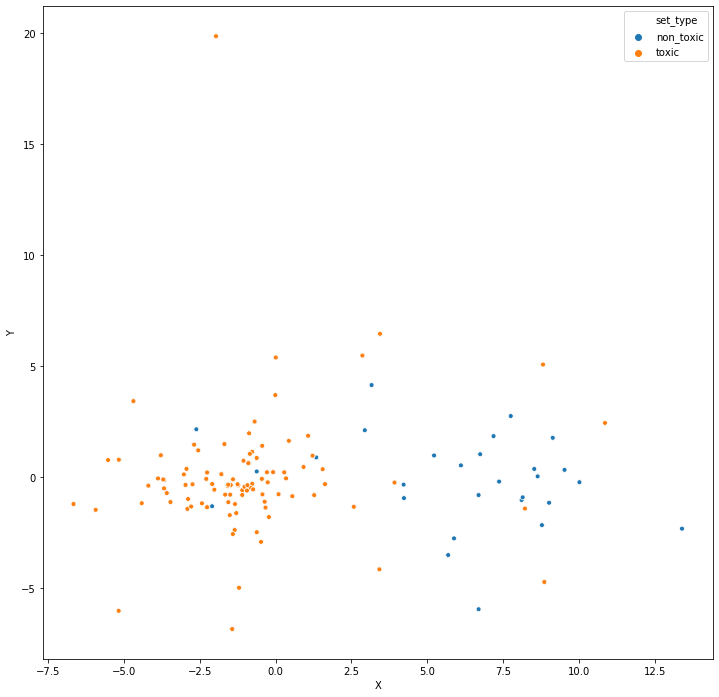

In [186]:
import seaborn as sns

i, j = 0, 2

arr1 = pd.DataFrame(trans_for_pca[:len(top_clean)][:,[i,j]], columns = ['X', 'Y'])
arr2 = pd.DataFrame(trans_for_pca[len(top_clean)+1:][:,[i,j]], columns = ['X', 'Y'])

plt.figure(figsize = (12, 12))

sns.scatterplot(
    x = 'X',
    y = 'Y',
    data = pd.concat([arr1.assign(set_type='non_toxic'), arr2.assign(set_type='toxic')]),
    s = 24, hue = 'set_type'
)

### Additional part: 

1. Find a pre-trained FastText vectors, understand it's difference from W2V vectors. 
2. Vectorize all of your texts using FT model, perform a text classification, calculate the metrics, compare with W2V approach. 

Or/And you can:

1. Train your own FT model and make the same. 
2. Compare it with previous approaches.

In [17]:
model_ft = FastText(sentences=df_sample_cleaned_list, 
                    size=300,
                    min_count=5,
                    window=5)

In [18]:
# model training
number_of_iterations = 50

model_ft.train(sentences=df_sample_cleaned_list, 
            total_examples=model_ft.corpus_count,
            epochs=number_of_iterations
           )

In [19]:
random_forest_cls_dat_5 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model_ft, cleaned_vocab, RandomForestClassifier, False
)

DATA PREPARATION START
MODEL TRAINING START
CONFUSION MATRIX:
[[17755    38]
 [  564   393]]
ACCURACY:
0.9678933333333334
TABLE:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17793
           1       0.91      0.41      0.57       957

    accuracy                           0.97     18750
   macro avg       0.94      0.70      0.77     18750
weighted avg       0.97      0.97      0.96     18750



In [20]:
random_forest_cls_dat_6 = quick_init_and_train_word_cls_model_no_args(
    X_train_t, X_test_t, Y_train, Y_test, model_ft, cleaned_vocab, RandomForestClassifier, True
)

DATA PREPARATION START
MODEL TRAINING START
CONFUSION MATRIX:
[[17761    32]
 [  534   423]]
ACCURACY:
0.9698133333333333
TABLE:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17793
           1       0.93      0.44      0.60       957

    accuracy                           0.97     18750
   macro avg       0.95      0.72      0.79     18750
weighted avg       0.97      0.97      0.96     18750



In [21]:
from joblib import dump

# saving models into c binary files, measures into dataframe
def save_model_and_get_fancy_stats(cls_dat, cls_name):
    dump(cls_dat[0], os.getcwd() + os.sep + cls_name + '.joblib')
    cls_measures = list(map(float, cls_dat[1][2][70:100].split()))
    # horrifying :D 
    return pd.Series({
        'tp': cls_dat[1][0][0][0],
        'tn': cls_dat[1][0][1][1],
        'fn': cls_dat[1][0][1][0],
        'fp': cls_dat[1][0][0][1],
        'pre': cls_measures[0],
        'rec': cls_measures[1],
        'f1': cls_measures[2],
        'acc': cls_dat[1][1]
    }, name = cls_name)

In [22]:
df_stats = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn', 'pre', 'rec', 'f1', 'acc'])
#df_stats.set_index('model', inplace=True)

In [48]:
del df_stats
df_stats = pd.read_csv(os.getcwd() + os.sep + 'models_t4.csv')

In [28]:
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_1, 'rf_w2v_trained'))
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_2, 'rf_w2v_trained_tfidf'))
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_3, 'rf_w2v_pretrained'))
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_4, 'rf_w2v_pretrained_tfidf'))
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_5, 'rf_ft_trained'))
#df_stats = df_stats.append(save_model_and_get_fancy_stats(random_forest_cls_dat_6, 'rf_ft_trained_tfidf'))

In [51]:
df_stats

,model,tp,tn,fp,fn,pre,rec,f1,acc
0,rf_ft_trained,17755.0,393.0,38.0,564.0,0.97,1.0,0.98,0.967893
1,rf_ft_trained_tfidf,17761.0,423.0,32.0,534.0,0.97,1.0,0.98,0.969813
2,rf_w2v_trained,17734.0,397.0,17.0,602.0,0.97,1.0,0.98,0.966987
3,rf_w2v_trained_tfidf,17738.0,401.0,13.0,598.0,0.97,1.0,0.98,0.967413
4,rf_w2v_pretrained,17738.0,331.0,13.0,668.0,0.96,1.0,0.98,0.963680
5,rf_w2v_pretrained_tfidf,17742.0,349.0,9.0,650.0,0.96,1.0,0.98,0.964853


In [52]:
df_stats.to_csv(os.getcwd() + os.sep + 'models_t4.csv')

### Conclusions: 

Please, provide a clear table or dataframe with all of the metrics for all of the trained/used models available.   

Compare them to each other.   

Make conclusions which one from your models worked better for this particular task.   
BE CAREFUL: Having a better model performance on this particular task does not matter that this model is better than others in GENERAL. You need to make your own conclusions about this particular model applied to this particular task. Please, think and understand WHY.   
Write your thoughts down below: 



Для поставленої задачі бінарної класифікаціх даних визначено, що непогані результати показала модель з використанням алгоритму Random Forest та набору навантажених tf-idf показниками текстових векторів, що були отримані з натренованої на наших даних моделі FastText.

Дійсно, хибно вважати що модель, яка проявила себе добре на одній задачі, буде давати добрі результати для інших.
Використані моделі у цьому завданні призначені для семантичного аналізу текстів.
Кілька слів про обрану модель в якості найкращої для задачі бінарної класифікації. Основними компонентами, що сприяли цьому, є наступні: навантаження векторизованих слів значеннями tf-idf (показник значущості слова дає змогу покращити роботу в цілому),
інструмент FastText/Word2Vec та дані, які були використані для тренування моделі та формування векторних представлень слів.